In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [6]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 20))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/15 [00:00<?, ?it/s]

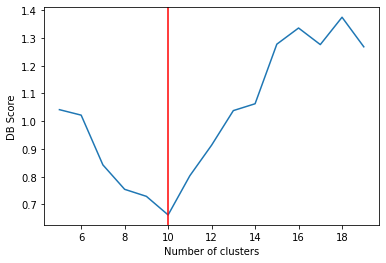

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

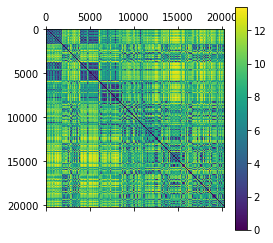

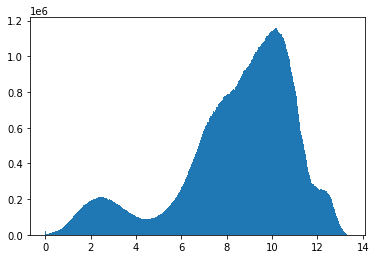

In [8]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

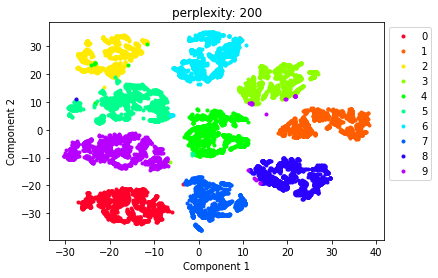

In [9]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [10]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [11]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [12]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [13]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [14]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.997930320800276


In [15]:
losses = []
accs = []
sparsity = []

In [ ]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.08428416273720142
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7108080110497237
layer 6: 0.587189226519337
layer 7: 0.4172133977900553
layer 8: 0.22405904696132597
layer 9: 0.11009797997237568
layer 10: 0.04828858770718232
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.302 | Reg loss: 0.021 | Tree loss: 2.302 | Accuracy: 0.109000 | 8.63 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.291 | Reg loss: 0.020 | Tree loss: 2.291 | Accuracy: 0.126000 | 8.643 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.280 | Reg loss: 0.020 | Tree loss: 2.280 | Accuracy: 0.235500 | 8.896 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.274 | Reg loss: 0.019 | Tree loss: 2.274 | Accuracy: 0.253500 | 9.158 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.262 | Reg loss: 0.019 | Tree loss: 2.262 | Accuracy: 0.293500 | 9.25 sec/iter
Epoch: 00 | Batch: 005 / 011 | Tota

Epoch: 04 | Batch: 008 / 011 | Total loss: 2.192 | Reg loss: 0.017 | Tree loss: 2.192 | Accuracy: 0.411500 | 13.665 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 2.183 | Reg loss: 0.017 | Tree loss: 2.183 | Accuracy: 0.365000 | 13.698 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 2.184 | Reg loss: 0.017 | Tree loss: 2.184 | Accuracy: 0.348123 | 13.565 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.280 | Reg loss: 0.016 | Tree loss: 2.280 | Accuracy: 0.318500 | 13.691 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.273 | Reg loss: 0.016 | Tree loss: 2.273 | Accuracy: 0.371000 | 13.731 sec/iter
Epoch: 05 | Batch: 002 / 01

Epoch: 09 | Batch: 005 / 011 | Total loss: 2.101 | Reg loss: 0.018 | Tree loss: 2.101 | Accuracy: 0.326500 | 14.405 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 2.059 | Reg loss: 0.018 | Tree loss: 2.059 | Accuracy: 0.302500 | 14.422 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 2.049 | Reg loss: 0.018 | Tree loss: 2.049 | Accuracy: 0.300000 | 14.429 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 2.025 | Reg loss: 0.018 | Tree loss: 2.025 | Accuracy: 0.316500 | 14.436 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 2.009 | Reg loss: 0.019 | Tree loss: 2.009 | Accuracy: 0.306500 | 14.446 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 2.015 | Reg loss: 0.019 | Tree loss: 2.015 | Accuracy: 0.293515 | 14.363 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 2.043 | Reg loss: 0.020 | Tree loss: 2.043 | Accuracy: 0.324000 | 14.777 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 1.984 | Reg loss: 0.020 | Tree loss: 1.984 | Accuracy: 0.327000 | 14.793 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 1.941 | Reg loss: 0.020 | Tree loss: 1.941 | Accuracy: 0.340500 | 14.776 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 1.905 | Reg loss: 0.020 | Tree loss: 1.905 | Accuracy: 0.341500 | 14.79 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 1.858 | Reg loss: 0.020 | Tree loss: 1.858 | Accuracy: 0.395000 | 14.81 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 1.832 | Reg loss: 0.021 | Tree loss: 1.832 | Accuracy: 0.383500 | 14.824 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 1.818 | Reg loss: 0.021 | Tree loss: 1.818 | Accuracy: 0.369000 | 14.839 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 1.802 | Reg loss: 0.021 | Tree loss: 1.802 | Accuracy: 0.335000 | 14.854 sec/iter
Ep

layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 1.966 | Reg loss: 0.022 | Tree loss: 1.966 | Accuracy: 0.340500 | 15.017 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 1.911 | Reg loss: 0.022 | Tree loss: 1.911 | Accuracy: 0.342000 | 15.019 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 1.855 | Reg loss: 0.022 | Tree loss: 1.855 | Accuracy: 0.370000 | 15.02 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 1.815 | Reg loss: 0.022 | Tree loss: 1.815 | Accuracy: 0.400500 | 15.019 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 1.765 | Reg loss: 0.023 | Tree loss: 1.765 | Accuracy: 0.414000 | 15.0 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 1.719 | Reg loss: 0.023 | Tree loss: 1.719 | Accuracy: 0.465000 | 15.007 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 1.677 | Reg loss: 0.023 | Tree loss: 1.677 | Accuracy: 0.457500 | 15.018 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 1.632 | Reg loss: 0.023 | Tree loss: 1.632 | Accuracy: 0

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 1.823 | Reg loss: 0.024 | Tree loss: 1.823 | Accuracy: 0.359000 | 15.115 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 1.771 | Reg loss: 0.024 | Tree loss: 1.771 | Accuracy: 0.396500 | 15.123 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 1.714 | Reg loss: 0.025 | Tree loss: 1.714 | Accuracy: 0.437000 | 15.13 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 1.655 | Reg loss: 0.025 | Tree loss: 1.655 | Accuracy: 0.511500 | 15.133 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 1.618 | Reg loss: 0.025 | Tree loss: 1.618 | Accuracy: 0.485000 | 15.117 sec/iter
Epoch: 24 | Batch: 005 / 011

Epoch: 28 | Batch: 008 / 011 | Total loss: 1.407 | Reg loss: 0.026 | Tree loss: 1.407 | Accuracy: 0.541000 | 15.204 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 1.394 | Reg loss: 0.026 | Tree loss: 1.394 | Accuracy: 0.537500 | 15.213 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 1.377 | Reg loss: 0.027 | Tree loss: 1.377 | Accuracy: 0.546075 | 15.189 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 1.695 | Reg loss: 0.026 | Tree loss: 1.695 | Accuracy: 0.461000 | 15.205 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 1.644 | Reg loss: 0.026 | Tree loss: 1.644 | Accuracy: 0.473000 | 15.206 sec/iter
Epoch: 29 | Batch: 002 / 01

Epoch: 33 | Batch: 005 / 011 | Total loss: 1.403 | Reg loss: 0.027 | Tree loss: 1.403 | Accuracy: 0.546500 | 15.156 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 1.389 | Reg loss: 0.028 | Tree loss: 1.389 | Accuracy: 0.533000 | 15.158 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 1.370 | Reg loss: 0.028 | Tree loss: 1.370 | Accuracy: 0.531000 | 15.159 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 1.336 | Reg loss: 0.028 | Tree loss: 1.336 | Accuracy: 0.537000 | 15.161 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 1.319 | Reg loss: 0.028 | Tree loss: 1.319 | Accuracy: 0.549500 | 15.162 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 1.304 | Reg loss: 0.028 | Tree loss: 1.304 | Accuracy: 0.525597 | 15.133 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 38 | Batch: 002 / 011 | Total loss: 1.452 | Reg loss: 0.028 | Tree loss: 1.452 | Accuracy: 0.571500 | 15.106 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 1.405 | Reg loss: 0.028 | Tree loss: 1.405 | Accuracy: 0.568500 | 15.106 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 1.361 | Reg loss: 0.029 | Tree loss: 1.361 | Accuracy: 0.588000 | 15.093 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 1.314 | Reg loss: 0.029 | Tree loss: 1.314 | Accuracy: 0.569000 | 15.093 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 1.330 | Reg loss: 0.029 | Tree loss: 1.330 | Accuracy: 0.548000 | 15.093 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 1.301 | Reg loss: 0.029 | Tree loss: 1.301 | Accuracy: 0.539000 | 15.094 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 1.270 | Reg loss: 0.029 | Tree loss: 1.270 | Accuracy: 0.559500 | 15.094 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 1.253 | Reg loss: 0.029 | Tree loss: 1.253 | Accuracy: 0.555500 | 15.094 sec/iter


layer 10: 0.9723756906077345
Epoch: 43 | Batch: 000 / 011 | Total loss: 1.491 | Reg loss: 0.029 | Tree loss: 1.491 | Accuracy: 0.520000 | 15.034 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 1.450 | Reg loss: 0.029 | Tree loss: 1.450 | Accuracy: 0.562500 | 15.038 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 1.379 | Reg loss: 0.030 | Tree loss: 1.379 | Accuracy: 0.616000 | 15.04 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 1.332 | Reg loss: 0.030 | Tree loss: 1.332 | Accuracy: 0.613000 | 15.043 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 1.303 | Reg loss: 0.030 | Tree loss: 1.303 | Accuracy: 0.599000 | 15.035 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 1.280 | Reg loss: 0.030 | Tree loss: 1.280 | Accuracy: 0.571500 | 15.039 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 1.250 | Reg loss: 0.030 | Tree loss: 1.250 | Accuracy: 0.592000 | 15.042 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 1.240 | Reg loss: 0.030 | Tree loss: 1.240 | Accuracy:

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 1.435 | Reg loss: 0.030 | Tree loss: 1.435 | Accuracy: 0.542500 | 15.072 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 1.385 | Reg loss: 0.030 | Tree loss: 1.385 | Accuracy: 0.594000 | 15.073 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 1.337 | Reg loss: 0.030 | Tree loss: 1.337 | Accuracy: 0.595500 | 15.075 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 1.284 | Reg loss: 0.031 | Tree loss: 1.284 | Accuracy: 0.616000 | 15.077 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 1.271 | Reg loss: 0.031 | Tree loss: 1.271 | Accuracy: 0.610000 | 15.07 sec/iter
Epoch: 48 | Batch: 005 / 011

Epoch: 52 | Batch: 008 / 011 | Total loss: 1.153 | Reg loss: 0.031 | Tree loss: 1.153 | Accuracy: 0.612500 | 15.103 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 1.150 | Reg loss: 0.032 | Tree loss: 1.150 | Accuracy: 0.600500 | 15.106 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 1.123 | Reg loss: 0.032 | Tree loss: 1.123 | Accuracy: 0.607509 | 15.087 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 1.353 | Reg loss: 0.031 | Tree loss: 1.353 | Accuracy: 0.589000 | 15.099 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 1.324 | Reg loss: 0.031 | Tree loss: 1.324 | Accuracy: 0.600500 | 15.1 sec/iter
Epoch: 53 | Batch: 002 / 011 

Epoch: 57 | Batch: 005 / 011 | Total loss: 1.154 | Reg loss: 0.032 | Tree loss: 1.154 | Accuracy: 0.652000 | 15.125 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 1.148 | Reg loss: 0.032 | Tree loss: 1.148 | Accuracy: 0.635500 | 15.126 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 1.134 | Reg loss: 0.032 | Tree loss: 1.134 | Accuracy: 0.644500 | 15.129 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 1.113 | Reg loss: 0.032 | Tree loss: 1.113 | Accuracy: 0.645500 | 15.131 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 1.142 | Reg loss: 0.032 | Tree loss: 1.142 | Accuracy: 0.614500 | 15.131 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 1.088 | Reg loss: 0.032 | Tree loss: 1.088 | Accuracy: 0.662116 | 15.117 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 62 | Batch: 002 / 011 | Total loss: 1.229 | Reg loss: 0.033 | Tree loss: 1.229 | Accuracy: 0.635000 | 15.157 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.193 | Reg loss: 0.033 | Tree loss: 1.193 | Accuracy: 0.650000 | 15.158 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.185 | Reg loss: 0.033 | Tree loss: 1.185 | Accuracy: 0.643000 | 15.15 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 1.148 | Reg loss: 0.033 | Tree loss: 1.148 | Accuracy: 0.650500 | 15.153 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 1.129 | Reg loss: 0.033 | Tree loss: 1.129 | Accuracy: 0.636000 | 15.155 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 1.111 | Reg loss: 0.033 | Tree loss: 1.111 | Accuracy: 0.619500 | 15.156 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 1.098 | Reg loss: 0.033 | Tree loss: 1.098 | Accuracy: 0.615000 | 15.156 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 1.096 | Reg loss: 0.033 | Tree loss: 1.096 | Accuracy: 0.599500 | 15.156 sec/iter
E

layer 10: 0.9723756906077345
Epoch: 67 | Batch: 000 / 011 | Total loss: 1.266 | Reg loss: 0.034 | Tree loss: 1.266 | Accuracy: 0.611500 | 15.168 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 1.226 | Reg loss: 0.034 | Tree loss: 1.226 | Accuracy: 0.620500 | 15.17 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.194 | Reg loss: 0.034 | Tree loss: 1.194 | Accuracy: 0.654000 | 15.171 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.171 | Reg loss: 0.034 | Tree loss: 1.171 | Accuracy: 0.657500 | 15.173 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.112 | Reg loss: 0.034 | Tree loss: 1.112 | Accuracy: 0.672000 | 15.169 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.097 | Reg loss: 0.034 | Tree loss: 1.097 | Accuracy: 0.692500 | 15.17 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.078 | Reg loss: 0.034 | Tree loss: 1.078 | Accuracy: 0.681500 | 15.172 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.086 | Reg loss: 0.034 | Tree loss: 1.086 | Accuracy: 

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 1.230 | Reg loss: 0.034 | Tree loss: 1.230 | Accuracy: 0.620500 | 15.196 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 1.218 | Reg loss: 0.034 | Tree loss: 1.218 | Accuracy: 0.616000 | 15.197 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 1.154 | Reg loss: 0.034 | Tree loss: 1.154 | Accuracy: 0.655000 | 15.199 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.120 | Reg loss: 0.034 | Tree loss: 1.120 | Accuracy: 0.671000 | 15.199 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.118 | Reg loss: 0.034 | Tree loss: 1.118 | Accuracy: 0.656000 | 15.195 sec/iter
Epoch: 72 | Batch: 005 / 01

Epoch: 76 | Batch: 008 / 011 | Total loss: 1.024 | Reg loss: 0.035 | Tree loss: 1.024 | Accuracy: 0.664000 | 15.203 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 0.999 | Reg loss: 0.035 | Tree loss: 0.999 | Accuracy: 0.683000 | 15.202 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 0.998 | Reg loss: 0.035 | Tree loss: 0.998 | Accuracy: 0.689420 | 15.193 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 1.199 | Reg loss: 0.035 | Tree loss: 1.199 | Accuracy: 0.641500 | 15.203 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 1.176 | Reg loss: 0.035 | Tree loss: 1.176 | Accuracy: 0.626500 | 15.203 sec/iter
Epoch: 77 | Batch: 002 / 01

Epoch: 81 | Batch: 005 / 011 | Total loss: 1.026 | Reg loss: 0.036 | Tree loss: 1.026 | Accuracy: 0.717000 | 15.217 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 1.008 | Reg loss: 0.036 | Tree loss: 1.008 | Accuracy: 0.706000 | 15.219 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 0.994 | Reg loss: 0.036 | Tree loss: 0.994 | Accuracy: 0.697500 | 15.222 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 0.982 | Reg loss: 0.036 | Tree loss: 0.982 | Accuracy: 0.706000 | 15.223 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 0.976 | Reg loss: 0.036 | Tree loss: 0.976 | Accuracy: 0.731000 | 15.223 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 1.060 | Reg loss: 0.036 | Tree loss: 1.060 | Accuracy: 0.682594 | 15.211 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 86 | Batch: 002 / 011 | Total loss: 1.099 | Reg loss: 0.036 | Tree loss: 1.099 | Accuracy: 0.658000 | 15.422 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 1.073 | Reg loss: 0.036 | Tree loss: 1.073 | Accuracy: 0.681500 | 15.428 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 1.044 | Reg loss: 0.036 | Tree loss: 1.044 | Accuracy: 0.688500 | 15.43 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 1.034 | Reg loss: 0.036 | Tree loss: 1.034 | Accuracy: 0.684000 | 15.429 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 0.979 | Reg loss: 0.036 | Tree loss: 0.979 | Accuracy: 0.691000 | 15.428 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 1.006 | Reg loss: 0.036 | Tree loss: 1.006 | Accuracy: 0.659500 | 15.428 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 0.977 | Reg loss: 0.036 | Tree loss: 0.977 | Accuracy: 0.678500 | 15.428 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 0.951 | Reg loss: 0.036 | Tree loss: 0.951 | Accuracy: 0.695000 | 15.43 sec/iter
Ep

layer 10: 0.9723756906077345
Epoch: 91 | Batch: 000 / 011 | Total loss: 1.144 | Reg loss: 0.037 | Tree loss: 1.144 | Accuracy: 0.629500 | 15.777 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 1.100 | Reg loss: 0.037 | Tree loss: 1.100 | Accuracy: 0.657000 | 15.772 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 1.066 | Reg loss: 0.037 | Tree loss: 1.066 | Accuracy: 0.689000 | 15.778 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 1.051 | Reg loss: 0.037 | Tree loss: 1.051 | Accuracy: 0.671500 | 15.784 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 1.012 | Reg loss: 0.037 | Tree loss: 1.012 | Accuracy: 0.708500 | 15.79 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 0.979 | Reg loss: 0.037 | Tree loss: 0.979 | Accuracy: 0.739000 | 15.795 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 0.946 | Reg loss: 0.037 | Tree loss: 0.946 | Accuracy: 0.756500 | 15.801 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 0.952 | Reg loss: 0.037 | Tree loss: 0.952 | Accuracy:

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 1.114 | Reg loss: 0.037 | Tree loss: 1.114 | Accuracy: 0.629500 | 15.971 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 1.098 | Reg loss: 0.037 | Tree loss: 1.098 | Accuracy: 0.640000 | 15.977 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 1.062 | Reg loss: 0.037 | Tree loss: 1.062 | Accuracy: 0.649000 | 15.983 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 1.017 | Reg loss: 0.037 | Tree loss: 1.017 | Accuracy: 0.688500 | 15.989 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 0.985 | Reg loss: 0.037 | Tree loss: 0.985 | Accuracy: 0.704000 | 15.995 sec/iter
Epoch: 96 | Batch: 005 / 01

Epoch: 100 | Batch: 008 / 011 | Total loss: 0.893 | Reg loss: 0.038 | Tree loss: 0.893 | Accuracy: 0.737500 | 16.146 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 0.899 | Reg loss: 0.038 | Tree loss: 0.899 | Accuracy: 0.755500 | 16.151 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 0.890 | Reg loss: 0.038 | Tree loss: 0.890 | Accuracy: 0.757679 | 16.139 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 1.103 | Reg loss: 0.038 | Tree loss: 1.103 | Accuracy: 0.654000 | 16.155 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 1.053 | Reg loss: 0.038 | Tree loss: 1.053 | Accuracy: 0.668500 | 16.16 sec/iter
Epoch: 101 | Batch: 002

Epoch: 105 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.038 | Tree loss: 0.933 | Accuracy: 0.741500 | 16.376 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.887 | Reg loss: 0.038 | Tree loss: 0.887 | Accuracy: 0.760000 | 16.371 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.893 | Reg loss: 0.038 | Tree loss: 0.893 | Accuracy: 0.748500 | 16.372 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 0.900 | Reg loss: 0.038 | Tree loss: 0.900 | Accuracy: 0.754500 | 16.377 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 0.881 | Reg loss: 0.038 | Tree loss: 0.881 | Accuracy: 0.761500 | 16.382 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 0.899 | Reg loss: 0.038 | Tree loss: 0.899 | Accuracy: 0.767918 | 16.373 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 110 | Batch: 002 / 011 | Total loss: 1.003 | Reg loss: 0.039 | Tree loss: 1.003 | Accuracy: 0.691500 | 16.606 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.978 | Reg loss: 0.039 | Tree loss: 0.978 | Accuracy: 0.712500 | 16.606 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.963 | Reg loss: 0.039 | Tree loss: 0.963 | Accuracy: 0.721500 | 16.604 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.926 | Reg loss: 0.039 | Tree loss: 0.926 | Accuracy: 0.718500 | 16.603 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.894 | Reg loss: 0.039 | Tree loss: 0.894 | Accuracy: 0.721000 | 16.601 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.883 | Reg loss: 0.039 | Tree loss: 0.883 | Accuracy: 0.738000 | 16.602 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 0.866 | Reg loss: 0.039 | Tree loss: 0.866 | Accuracy: 0.746000 | 16.606 sec/iter
Epoch: 110 | Batch: 009 / 011 | Total loss: 0.860 | Reg loss: 0.039 | Tree loss: 0.860 | Accuracy: 0.741000 | 16.61 se

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [ ]:
print(f"Number of patterns: {len(root.get_leaves())}")

In [ ]:
method = 'MLE'

In [ ]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [ ]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")